In [53]:
import pandas as pd
import numpy as np
import riskfolio as rp
import yfinance as yf
import matplotlib.pyplot as plt
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [54]:
#Read in data and set index as the date
df = pd.read_csv('yf_df.csv')
df.set_index('Date', inplace = True)
df.index = pd.to_datetime(df.index)
df


,BTC,ETH,XRP,DOGE,LINK
Date,,,,,
2020-05-11,8601.795898,185.912842,0.194064,0.002413,3.585065
2020-05-12,8804.477539,189.312500,0.197637,0.002463,3.692374
2020-05-13,9269.987305,199.193283,0.201480,0.002521,3.760424
2020-05-14,9733.721680,202.949097,0.203129,0.002574,3.799387
2020-05-15,9328.197266,195.622665,0.198911,0.002506,3.674653
...,...,...,...,...,...
2024-05-24,68526.101562,3726.934570,0.535753,0.163803,17.247709
2024-05-25,69265.945312,3749.236572,0.541809,0.173960,17.441204
2024-05-26,68518.093750,3825.897461,0.528211,0.166220,17.046471


In [55]:
#Setting benchmark as the S&P500
benchmark = yf.download('^GSPC', start = '2020-05-11', end = '2024-05-21')
benchmark = benchmark[('Adj Close')]

[*********************100%%**********************]  1 of 1 completed


In [56]:
#Get returns
returns = df.pct_change().dropna() #Overall returns for each asset
returns_bench = benchmark.pct_change().dropna()

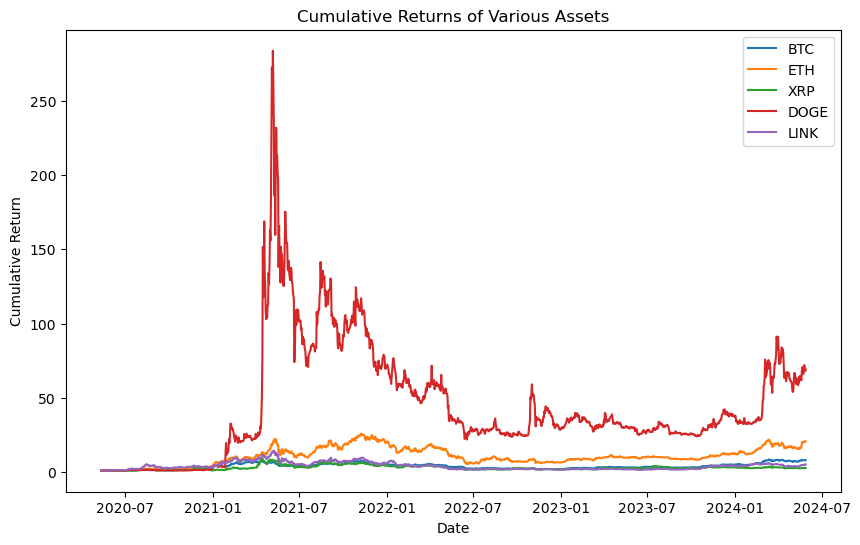

In [57]:
#Calculate the cumulative returns
cumulative_returns = (1 + returns).cumprod()

#Plot the cumulative returns
plt.figure(figsize=(10, 6))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

#Add title and labels
plt.title('Cumulative Returns of Various Assets')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()

plt.show()

In [58]:
#Building portfolio object
port = rp.Portfolio(returns, nea = 4) #Number of Effective Assets (NEA)

port.assets_stats(
    method_mu = 'hist', #Selected method to estimate expected returns based on historical data
    method_cov = 'hist', #Selected method to estimate covariance matrix based on historical data
    d = 0.94)

port.benchindex = returns_bench

In [59]:
#Estimate optimal portfolio for mean/cvar ratio
w = port.optimization(
    model = 'Classic', #Either classic, BL(Black Litterman), FM(Factor model), BLFM(Black Litterman w/Factor models)
    rm = 'CVaR', #Risk measure
    obj = 'Sharpe', #Objective function, could be MinRisk, MaxRet, Utility or Sharpe
    hist = True, #Use historical scenarios for risk measures
    rf = 0, #Risk free rate
    l = 0) #Risk aversion factor, only useful when obj is 'utility'
w #Optimal weights for our portfolio

,weights
BTC,0.180017
ETH,0.198808
XRP,0.138580
DOGE,0.386927
LINK,0.095668


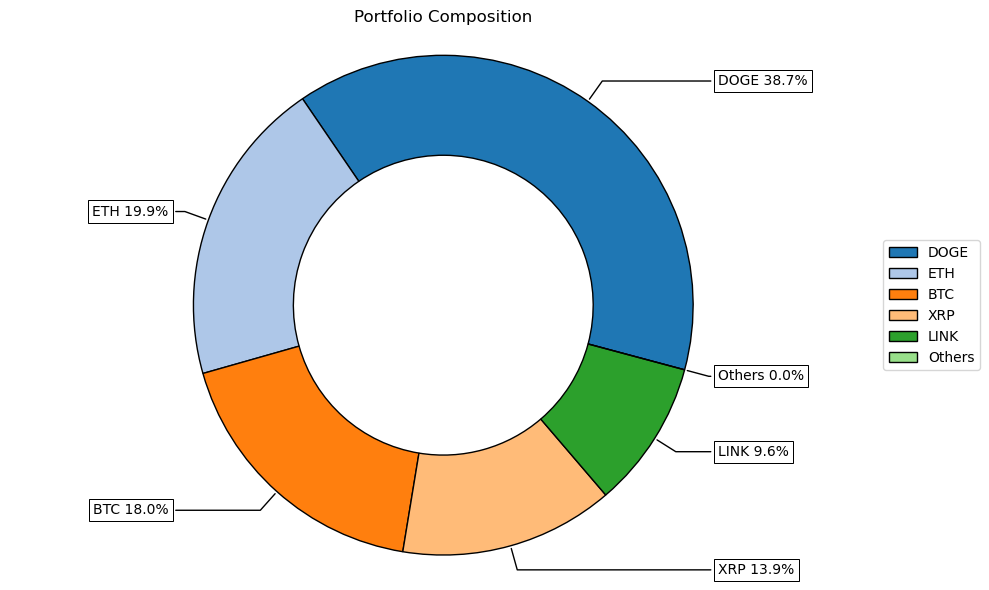

In [60]:
#Plotting optimal portfolio composition
ax = rp.plot_pie(
    w = w,
    others = 0.05,
    nrow = 25,
    cmap = 'tab20',
    height = 6,
    width = 10,
    ax = None)

In [61]:
#Calculate efficient frontier
frontier = port.efficient_frontier(model = 'Classic', #Optimization model
                                   rm = 'CVaR', #Risk measure
                                   rf = 0, #Risk free rate
                                   hist = True) #Use historical scenarios as risk measures

display(frontier.T.head())

,BTC,ETH,XRP,DOGE,LINK
0,0.367472,0.237390,0.186572,0.136308,0.072257
1,0.350426,0.240877,0.156317,0.206493,0.045887
2,0.338314,0.237732,0.147519,0.235832,0.040603
3,0.324661,0.236964,0.141066,0.258989,0.038320
4,0.312329,0.236399,0.132615,0.278089,0.040568


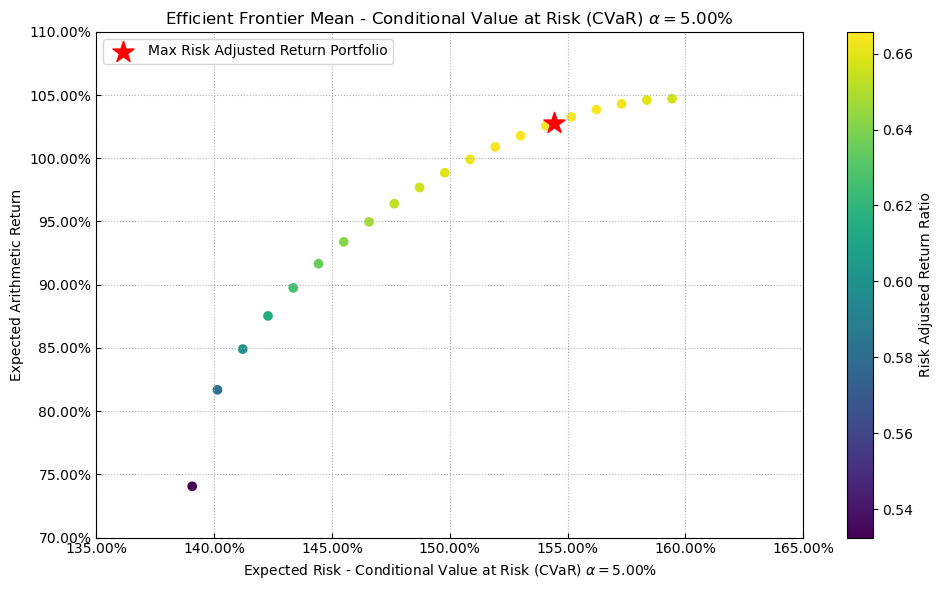

In [62]:
#Plot efficient frontier

ax = rp.plot_frontier(w_frontier = frontier, #Frontier calculated from lines above
                      mu = port.mu, #Expected returns
                      cov = port.cov, #Covariance matrix
                      returns = port.returns, #Returns of assets
                      rm = 'CVaR', #Risk measure
                      rf = 0, #Risk free rate
                      alpha = 0.05, #Significance level
                      w = w, #Weights of portfolio
                      label = 'Max Risk Adjusted Return Portfolio',
                      )

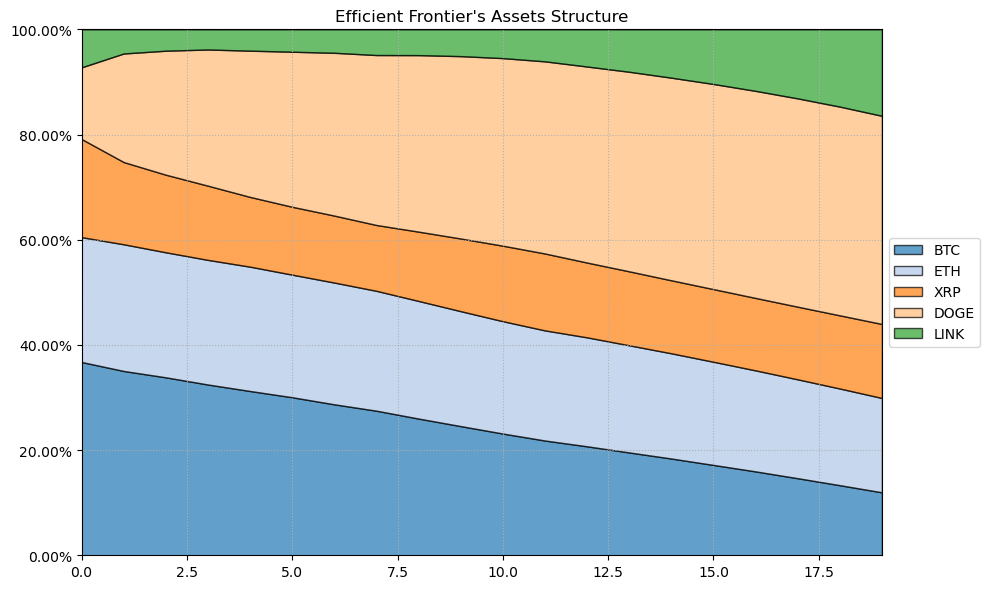

In [63]:
#Plot efficient frontier composition

ax = rp.plot_frontier_area(w_frontier = frontier) #Weights of portfolios in efficient frontier

<Axes: title={'center': 'Historical Compounded Cumulative Returns'}>

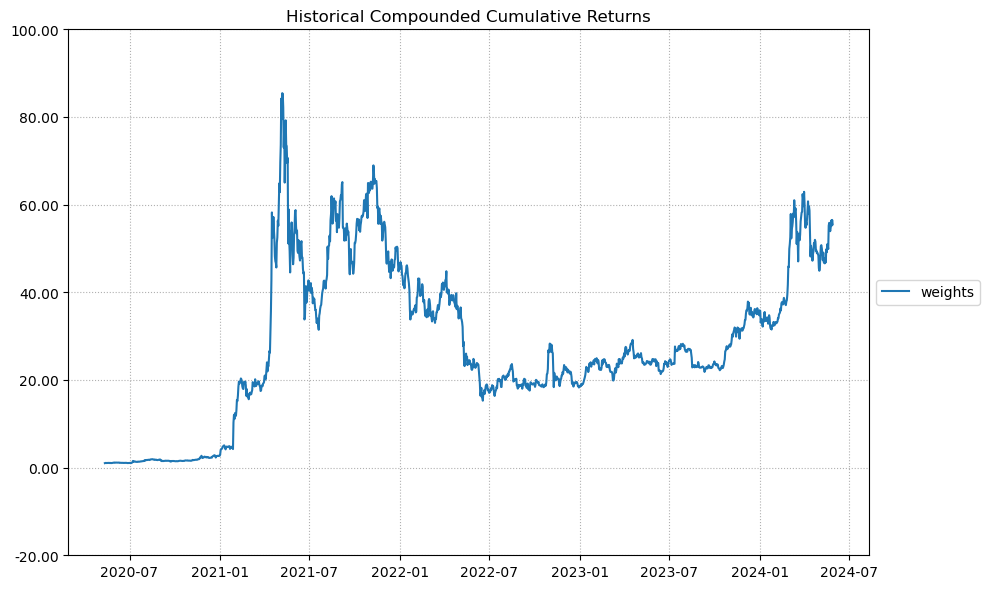

In [64]:
#Compounded returns
rp.plot_series(returns = returns, w = w)

array([<Axes: title={'center': 'Historical Compounded Cumulative Returns'}>,
       <Axes: title={'center': 'Historical Uncompounded Drawdown'}>],
      dtype=object)

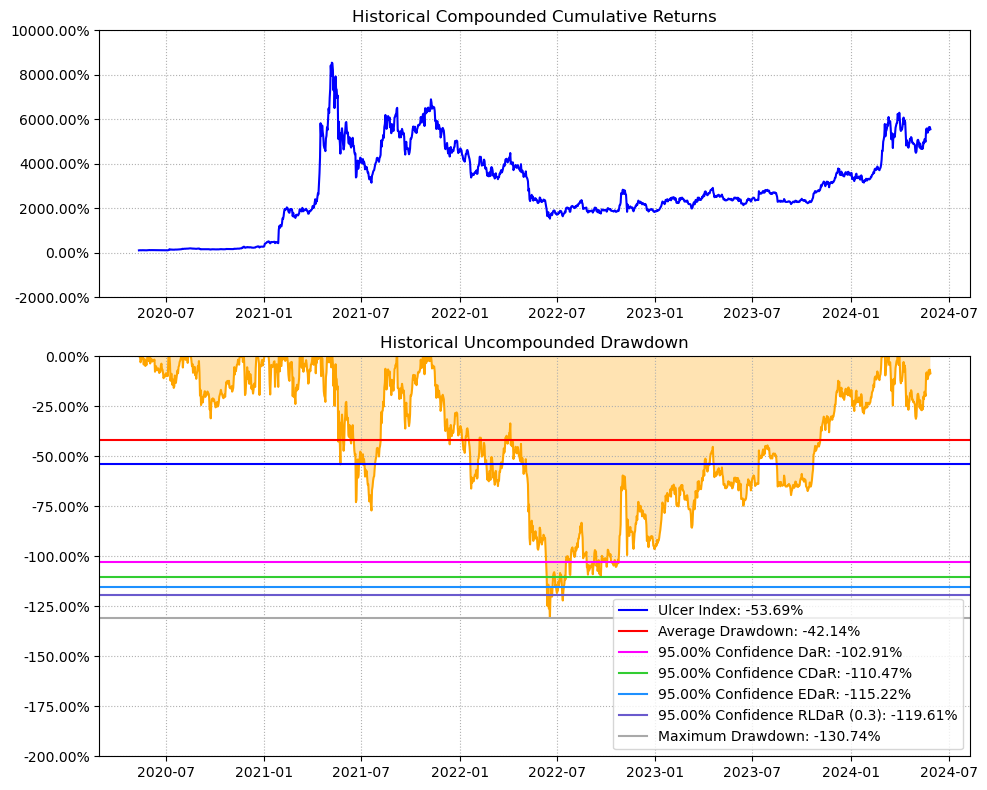

In [65]:
#Compounded returns + max drawdown
rp.plot_drawdown(returns, w)

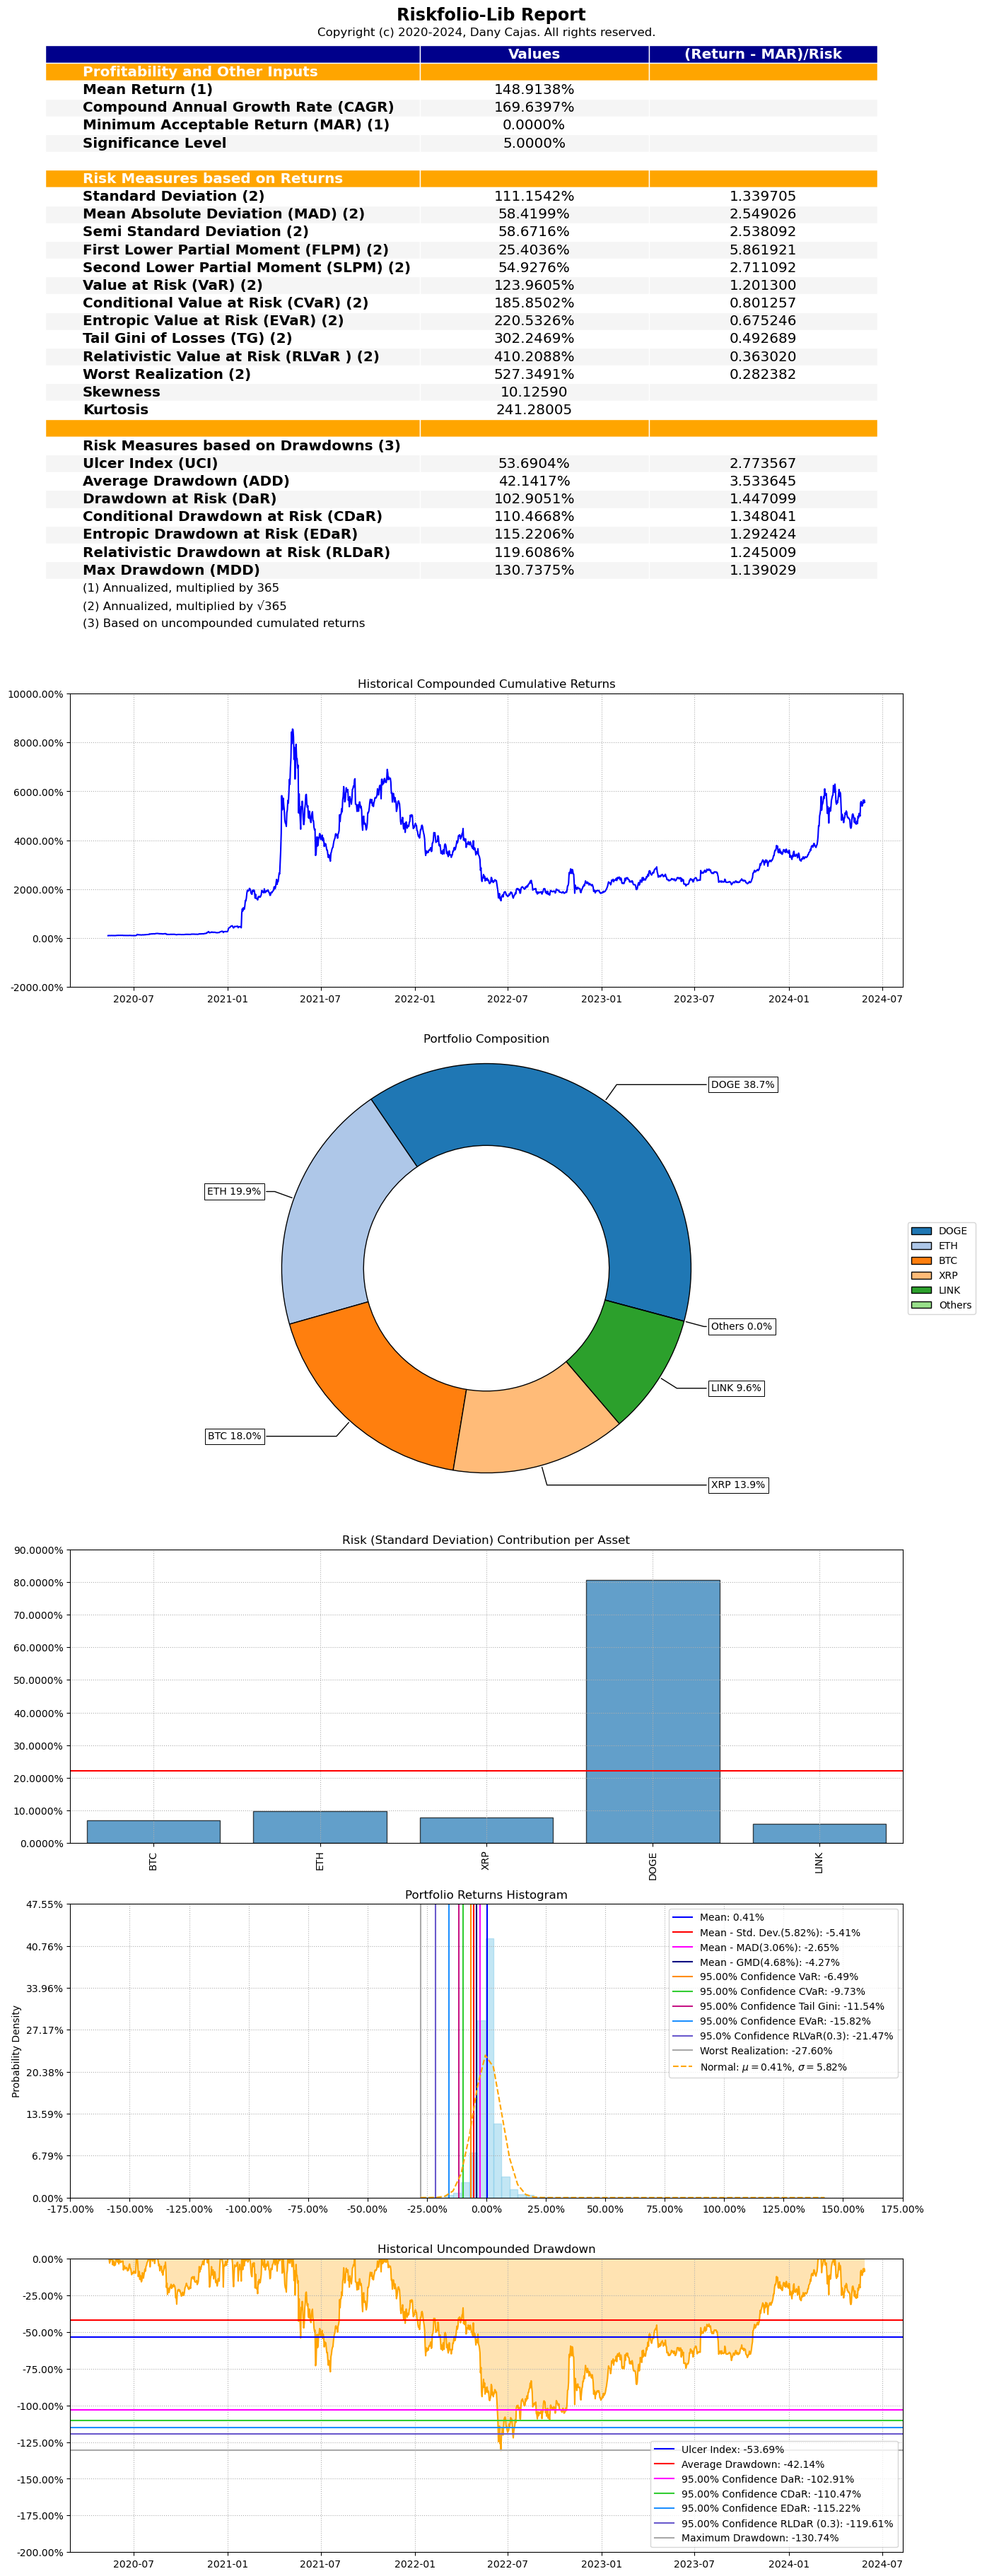

In [66]:
ax = rp.jupyter_report(returns,
                       w = w, #Portfolio weights
                       rm='MV', #Risk measure used 
                       rf=0, #Risk free rate
                       alpha=0.05,
                       t_factor=365, #Factor used to annualize expected return & expected risks 
                       days_per_year=365) #Number of days in year

In [67]:
rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model='Classic', rm='MV', obj='Sharpe', rf=0, l=0, hist=True)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
BTC,24.33%,24.33%,24.33%,24.33%,24.33%,24.33%,24.33%,24.33%,24.33%,24.33%,24.33%,24.33%,24.33%
ETH,36.55%,36.55%,36.55%,36.55%,36.55%,36.55%,36.55%,36.55%,36.55%,36.55%,36.55%,36.55%,36.55%
XRP,9.36%,9.36%,9.36%,9.36%,9.36%,9.36%,9.36%,9.36%,9.36%,9.36%,9.36%,9.36%,9.36%
DOGE,19.43%,19.43%,19.43%,19.43%,19.43%,19.43%,19.43%,19.43%,19.43%,19.43%,19.43%,19.43%,19.43%
LINK,10.33%,10.33%,10.33%,10.33%,10.33%,10.33%,10.33%,10.33%,10.33%,10.33%,10.33%,10.33%,10.33%


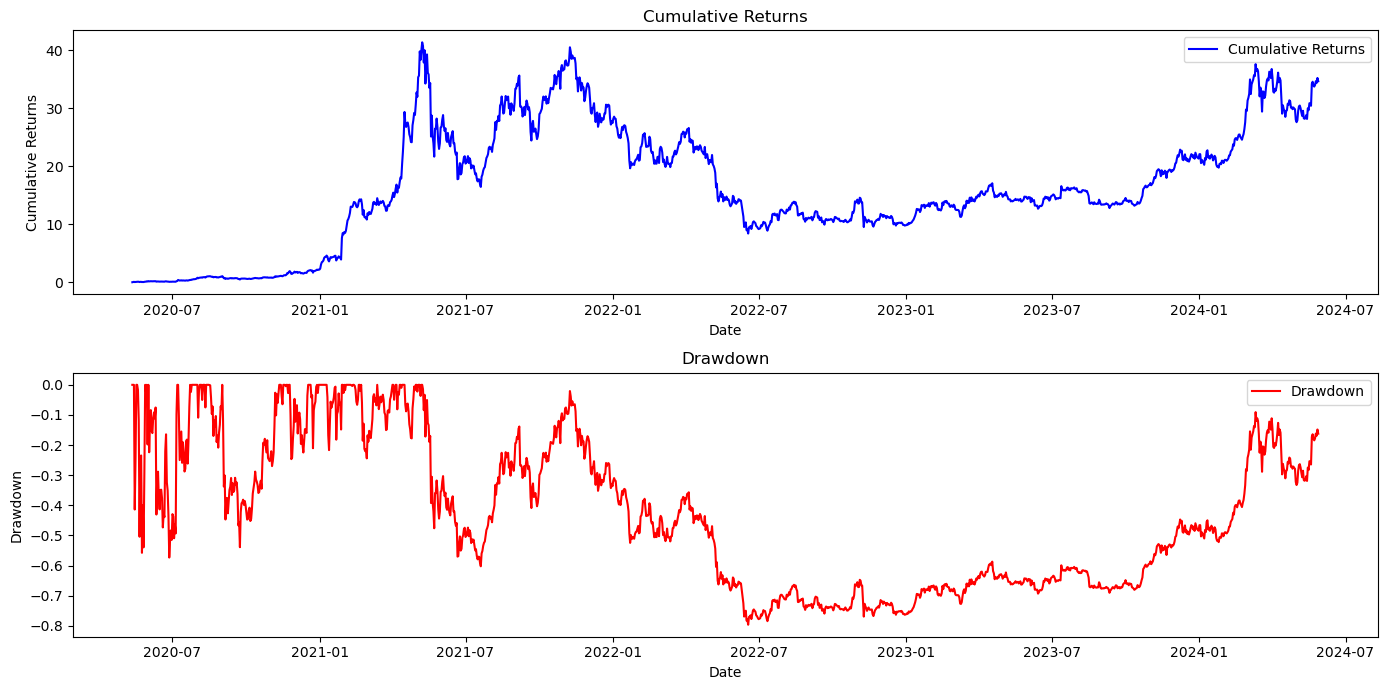

Maximum Drawdown: -79.65%


In [68]:
weights = w.iloc[:, 0]

#Calculate daily returns from daily closing prices
returns = df.pct_change().dropna()

#Calculate the portfolio returns
portfolio_returns = (returns * weights).sum(axis=1)

#Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod() - 1

#Calculate running maximum
running_max = np.maximum.accumulate(cumulative_returns)
running_max[running_max < 0] = 0

#Calculate drawdowns
drawdown = (cumulative_returns - running_max) / running_max

#Calculate max drawdown
max_drawdown = drawdown.min()

#Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(cumulative_returns, label='Cumulative Returns', color='blue')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()

#Plot drawdowns
plt.subplot(2, 1, 2)
plt.plot(drawdown, label='Drawdown', color='red')
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Maximum Drawdown: {max_drawdown:.2%}")

In [73]:
# Assuming 'port' is your Portfolio object and 'w' are the weights for the portfolio

# Risk-free rate
rf_rate = 0  # Risk-free rate is 0

# Extract the expected returns and covariance matrix from the portfolio object
mu = port.mu.values.flatten()  # Expected returns
cov = port.cov.values  # Covariance matrix

# Ensure weights are in the correct format
weights = w.values.flatten()

# Calculate portfolio return and volatility
port_return = np.dot(weights, mu)
port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))

# Calculate daily Sharpe ratio
sharpe_ratio = port_return / port_volatility

# Annualize the Sharpe ratio
sharpe_ratio_annualized = sharpe_ratio * np.sqrt(365)

print(f"Daily Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Annualized Sharpe Ratio: {sharpe_ratio_annualized:.4f}")

Daily Sharpe Ratio: 0.0757
Annualized Sharpe Ratio: 1.4469
